In [29]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import pandas as pd
from scipy import interpolate

import math
import warnings
warnings.filterwarnings('ignore')

tf.set_random_seed(1234)

In [2]:
print(tf.__version__)

1.15.0


# Load data from Phillips et al

In [9]:
folderName = '../data/phillips/'

phi_file = folderName  + "couette_phi.csv"
u_file = folderName  + "couette_u.csv"

df_phi = pd.read_csv(phi_file, header = None, names= ['y', 'phi'])
df_phi = df_phi.sort_values(by=['y'])
df_u = pd.read_csv(u_file, header = None, names= ['y', 'u'])
df_u = df_u.sort_values(by=['y'])
df_u = df_u.drop(axis = 0, index = [30])
# fit phi values
f = interpolate.interp1d(df_phi['y'], df_phi['phi'], fill_value= 'extrapolate' )

kappa = 0.64/2.38
y_coord = np.linspace(kappa, 1, 2000)
phi_fitted = f(y_coord)

# fit u
f = interpolate.interp1d(df_u['y'], df_u['u'], fill_value= 'extrapolate' )
u_fitted = f(y_coord)

# create a data frame
d = {'y': y_coord, 'phi': phi_fitted, 'u': u_fitted}
df = pd.DataFrame(data=d)

In [23]:
class PINN_twoNNs:
    # Initialize the class
    def __init__(self, r, u, phi, layersU, layersPhi, l1, phi_b, kappa):
        
        self.l1 = l1
        self.r = r
        self.kappa = kappa
        self.rb =  np.array([[1], [self.kappa]])
        self.ub =  np.array([[0], [1]])
        self.u = u
       
        self.phi = phi
        self.phi_b = phi_b
       
        self.layersU = layersU
        self.layersPhi = layersPhi

        # Initialize NN
        self.weightsU, self.biasesU = self.initialize_NN_u(self.layersU) 
        self.weightsPhi, self.biasesPhi = self.initialize_NN_phi(self.layersPhi)        
       
        # Initialize parameters
        self.lambda1 = tf.Variable([self.l1], dtype=tf.float32)        

        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        self.r_tf = tf.placeholder(tf.float32, shape=[None, self.r.shape[1]])        
        self.phi_tf = tf.placeholder(tf.float32, shape=[None,  self.phi.shape[1]])
        self.u_tf = tf.placeholder(tf.float32, shape=[None, self.u.shape[1]])

        self.u_pred = self.net_NS_u(self.r_tf)
        self.ur_pred = tf.gradients(self.u_pred, self.r_tf)[0]
        self.urr_pred = tf.gradients(self.ur_pred, self.r_tf)[0]
        
        self.gamma_pred = self.kappa*(-self.u_pred/self.r_tf + self.ur_pred)
        self.gammar_pred = self.kappa*(self.urr_pred - self.ur_pred/self.r_tf +\
                                       self.u_pred/self.r_tf**2 )

        self.phi_pred = self.net_NS_phi(self.r_tf)
        self.phir_pred = tf.gradients(self.phi_pred, self.r_tf)[0]
        
        self.eta = (1 - self.phi_pred/0.68)**(-1.82)
        self.eta_r = 1.82*(1- self.phi_pred/0.68)**(-2.82)*self.phir_pred/0.68
        
        self.tmp = tf.reduce_sum(1/self.r_tf**3/self.eta)*(1-self.kappa)/self.r.shape[0]
        
        self.g_pred = self.gamma_pred*self.r_tf**2*self.eta*self.tmp + 1 
       
        self.f_pred = self.gammar_pred/self.gamma_pred + self.phir_pred/self.phi_pred + self.lambda1/self.eta*self.eta_r

        # loss function
        self.loss = tf.reduce_mean(tf.square(self.u_tf - self.u_pred)) + \
                    tf.reduce_mean(tf.square(self.phi_tf - self.phi_pred)) + \
                    tf.reduce_mean(tf.square(self.f_pred)) + \
                    tf.reduce_mean(tf.square(self.g_pred)) +\
                    tf.square(tf.reduce_mean(self.phi_pred) - self.phi_b) 
                  
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})        
        
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)                    
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN_u(self, layersU):        
        weights = []
        biases = []
     
        num_layers = len(layersU) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layersU[l], layersU[l+1]])
            b = tf.Variable(tf.zeros([1,layersU[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)   

        return weights, biases

    def initialize_NN_phi(self, layersPhi):        
        weights = []
        biases = []
     
        num_layers = len(layersPhi) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layersPhi[l], layersPhi[l+1]])
            b = tf.Variable(tf.zeros([1,layersPhi[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)   

        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net_u(self, X, weights, biases):
        num_layers = len(weights) + 1

        H = X
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def neural_net_phi(self, X, weights, biases):
        num_layers = len(weights) + 1

        H = X
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def net_NS_u(self,r):
     
        u = self.neural_net_u(r, self.weightsU, self.biasesU) # 

        u = u[:,0:1] 

        return u

    def net_NS_phi(self,r):
     
        phi = self.neural_net_phi(r, self.weightsPhi, self.biasesPhi) # 

        phi = phi[:,0:1]
        
        phi_r = tf.gradients(phi, r)[0]


        return phi
     
    def train(self, nIter): 

        tf_dict = {self.r_tf: self.r, self.u_tf: self.u, self.phi_tf: self.phi}
        
        start_time = time.time()
        Iteration, Loss, L1  = [0,], [float('inf')], [self.l1,]
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict) 

            if it % 100 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                Iteration.append(it)
                Loss.append(np.log(loss_value))
                
        print("Iterations done." )
        self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss, self.lambda1])
        
        print(self.sess.run(self.loss, tf_dict) )
   
        loss_value = self.sess.run(self.loss, tf_dict)
        return Iteration, loss_value
  
    def predict(self, r_star):
        
        tf_dict = {self.r_tf: r_star}
        
        u_star = self.sess.run(self.u_pred, tf_dict)
        phi_star = self.sess.run(self.phi_pred, tf_dict)

        return u_star, phi_star



In [30]:
N_train = len(df)
phi_b = .55

layersU = [1, 10,10 , 1]
layersPhi = [1, 10, 10, 1]
# Load Data
N = len(df)
U_star = df['u'].values  
U_star = U_star.reshape(N,1)
Phi_star = df['phi'].values 
Phi_star = Phi_star.reshape(N,1)

y = df['y'].values 
R_star = y.reshape(N,1)

# Training Data    
idx = np.random.choice(N, N_train, replace=False)
r_train = R_star[idx]
u_train = U_star[idx]
phi_train = Phi_star[idx]  

l1 = 1
kappa = 0.64/2.38

model = PINN_twoNNs(r_train, u_train, phi_train, layersU, layersPhi, l1,  phi_b, kappa)    

Iteration, Loss = model.train(12000)
print("Loss", Loss)
# Test Data
r_star = R_star 
u_star = U_star
phi_star = Phi_star
# Prediction
u_pred, phi_pred= model.predict(r_star)

lambda_1_value = model.sess.run(model.lambda1)

print("ratio: " , 1/lambda_1_value[0])

model.sess.close()
print(sum((phi_pred - Phi_star)**2)/len(Phi_star))
print(sum((u_pred - u_star)**2)/len(u_star))

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

Iterations done.
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.002006
  Number of iterations: 484
  Number of functions evaluations: 607
0.002005962
Loss 0.002005962
ratio:  0.6940873061807767
[0.00032557]
[0.00065668]


In [31]:
from scipy.optimize import root_scalar as nsolve
from scipy.integrate import *

class solve_ode:
    def __init__(self, phi_b): 
        self.phi_b = phi_b
        self.phi_m = 0.68
        self.kappa = 0.64/2.38 
        self.a = 1.82
        self.ratio = 0.66 # K_c/K_eta
        self.Npts = 30
        self.r_dist = np.linspace(self.kappa, 1, self.Npts)

        self.mytol = 1e-12
       
    def solve(self):
        sol = nsolve(self.func, bracket=[0.1, 0.6], method='brentq', 
                     options={"disp":True, "xtol":self.mytol, "rtol":self.mytol})
        return self.phi
            
    # implements Phillips et al. Eq. (21)
    def ode_fun(self, r, phi):
        eta = (1 - phi/self.phi_m)**(-self.a)
        detadf_over_eta = self.a/self.phi_m*(1 - phi/self.phi_m)**(-1)
        numer = 2*self.ratio*phi**2
        denom = (self.ratio*phi + (1-self.ratio)*(phi**2)*detadf_over_eta)*r
        return numer/denom
    
    def func(self, phi0):

        sol = solve_ivp(self.ode_fun, [self.kappa, 1], [phi0], t_eval = self.r_dist, 
                        atol = self.mytol, rtol = self.mytol)
        self.phi = sol.y[0]  

        self.I = simps(self.phi, self.r_dist) # note it is dr, not r*dr
        diffI = self.I - self.phi_b*(1 - self.kappa)    
        return diffI

In [32]:
# Solving ODE
import numpy as np
phi_sol = solve_ode(0.55).solve()

In [33]:
# Fig 7
# approximated theory from Phillips et al
def theory_phillips():
    phib = 0.55
    kappa = 0.64/2.38
    phim = 0.68
    mytol = 10**(-5)
    def func(alpha):
        return phib - 2*phim/(1-kappa**2)*((1-kappa**2)/2 - alpha*kappa**2/2*np.log((1+alpha*kappa**2)/(kappa**2*(1+alpha))))

    sol = nsolve(func, bracket = [0, 3], method='brentq', xtol=mytol, rtol=mytol) 
    r = np.linspace(kappa, 1, 30)
    phi = phim*r**2/(r**2 + sol.root *kappa**2)
    
    return r, phi
phillips_r, phillips_phi = theory_phillips()

In [34]:
from matplotlib import rc

font = {'family' : 'sans-serif',
        'sans-serif': ['Helvetica'],#['Helvetica'],
        'weight' : 'normal',
        'size': 10}

rc('font', **font) 
rc('text', usetex=True)

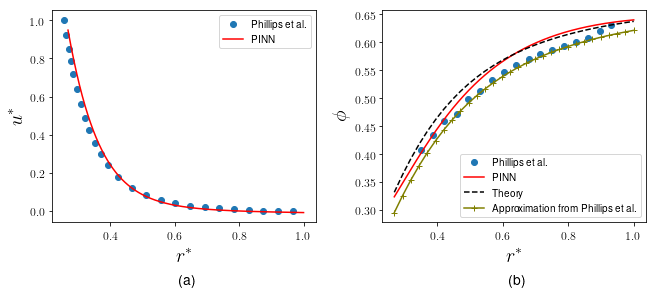

In [35]:
figwidth = 9
figheight = 4
labelsize = 20
legendsize = 10
ticksize = 12

fig = plt.figure(figsize=(figwidth,figheight),constrained_layout=True)
widths = [figwidth/2, figwidth/2]
heights = [figheight]
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths,
                          height_ratios=heights)
axes = []
for col in range(2):
    axes.append(fig.add_subplot(spec[0, col]))

axes[0].plot(df_u['y'][::3], df_u['u'][::3], 'o', label = "Phillips et al.")
axes[1].plot(df_phi['y'], df_phi['phi'], 'o',label = "Phillips et al.")

axes[0].plot(df['y'], u_pred, 'r',label = "PINN")
axes[1].plot(df['y'], phi_pred, 'r',label = "PINN")

axes[1].plot(np.linspace(kappa, 1, 30), phi_sol, '--',color = 'k',label = "Theory")
axes[1].plot(phillips_r, phillips_phi, '+-',color = 'olive',label = "Approximation from Phillips et al.")

axes[0].legend(fontsize=legendsize)
axes[1].legend(fontsize=legendsize)

axes[0].set_xlabel(r"$r^*$", fontsize=labelsize)
axes[0].set_ylabel(r"$u^*$", fontsize=labelsize)

axes[1].set_xlabel(r"$r^*$", fontsize=labelsize)
axes[1].set_ylabel(r"$\phi$", fontsize=labelsize)

axes[0].tick_params(axis='both', labelsize=ticksize )   
axes[1].tick_params(axis='both', labelsize=ticksize )   

import string
for n, ax in enumerate(axes):
    ax.text(0.48, -0.3, "(" + string.ascii_lowercase[n]+")", transform=ax.transAxes, 
                size=14, weight='normal')


# Plot training errors

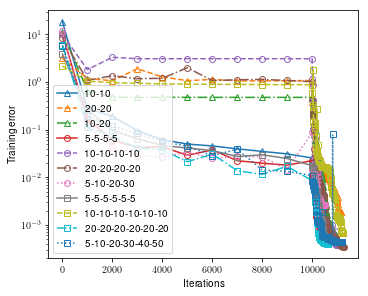

In [37]:
layers = ["two", "realfour","six"]
legends = [["10-10", "20-20", "10-20"], ["5-5-5-5", "10-10-10-10", "20-20-20-20", "5-10-20-30" ],
           ["5-5-5-5-5-5", "10-10-10-10-10-10", "20-20-20-20-20-20", "5-10-20-30-40-50"]]
markers = [['-^','--^', '-.^'], 
          ['-o', '--o', '-.o',':o'],
          ['-s', '--s', '-.s', ':s']]
folderName = '../data/phillips/errors/'
figwidth = 5
figheight = 4
labelsize = 20
legendsize = 10
ticksize = 12
fig = plt.figure(figsize=(figwidth,figheight),constrained_layout=True)
widths = [figwidth/2, figwidth/2]
heights = [figheight]

for j, layer in enumerate(layers):

    if layer == "two":
        idices = range(3)
    else:
        idices = range(4)
    for idx in idices:
        f = open(folderName + 'pinn_couette_' + layer + '_layers' + str(idx)+ '.txt', 'r')
        pinn_couette = f.read().split('\n')
        for i in range(0, 2, 2):
            iters = [float(it) for it in pinn_couette[i][1:-1].split(",")]
            loss = [10**float(lo) for lo in pinn_couette[i+1][1:-1].split(",")]
            
            plt.semilogy(iters[::10], loss[::10],  markers[j][idx],fillstyle = 'none', label = legends[j][idx])
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Training error");